# Week 7 : Multi-Resolution Splines

Date : 25th November, 2021

Today we will be looking at blending images using multi-resolution splines. We will first start off by building a Gaussian pyramid, followed by a Laplacian Pyramid. We will then look at how to combine two Laplacian Pyramids to blend two images together to replicate the classic orange and apple image shown further down.



In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline #to visualize the plots within the notebook

UsageError: unrecognized arguments: #to visualize the plots within the notebook


## Task 1: Gaussian Pyramid

To build a Gaussian Pyramid	we will first need to create a method that will apply a Kernel to our image. We can	do this using 2D fast fourier transform(fft2), and inverse fourier transform(ifft).

$\fbox{ Image } \rightarrow \fbox{fft2}$ 

$\hfill$$\hfill$$\hfill$$\hfill$$\searrow$

$\hfill$$\hfill$$\hfill$$\hfill$$\hfill$$\fbox{*}\rightarrow\fbox{ifft}\rightarrow\fbox{Filtered Image}$

$\hfill$$\hfill$$\hfill$$\hfill$$\nearrow$

$\fbox{Filter H} \rightarrow \fbox{fft2} $

Our filter H can be computed with the following formula

### $H_\sigma = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$

A Gaussian pyramid can be built by blurring and down-sampling, guving us a sequence of low-pass filtered images $G_0, G_1, G_2, ..., G_n$:

![Gaussian Pyramid](../images/W7-Gaussian.png)

## Task 2: Laplacian Pyramid

Next it’s time to build a (band-pass) Laplacian pyramid. This can be built using your Gaussian pyramid, each level	will be	computed by	taking the difference from one level to the next, therefore:

$L_i = G_i - \text{EXPAND}(G_{i+1})$

Resulting in $L_0, L_1, L_2, ..., L_n$, where EXPAND upscales the image.

![Laplacian Pyramid](../images/W7-Laplacian.png)

## Task 3: Multi-Resolution Spline

Once we have the methods that will create out Gaussian and Laplacian pyramids, we can use these to blend out images together using the following algorithm:

1) First compute the Laplacian pyramids $LA$ and $LB$ for images A and B
2) We then need to create a mask that will be used to blend out images.
3) Once we have a mask, we want to create a Gaussian pyramid of the mask, $GR$.
4) We now need to compute the Laplacian pyramid LS that is a combination of $LA$ and $LB$, computed by

$$LS_i = GR_i(i,j)LA_i(i,j) + (1-GR_i(i,j))LB_i(i,j)$$

5) The pyramid LS now needs to be expanded, this is done by simply upscaling and adding each level.

#### First, load images

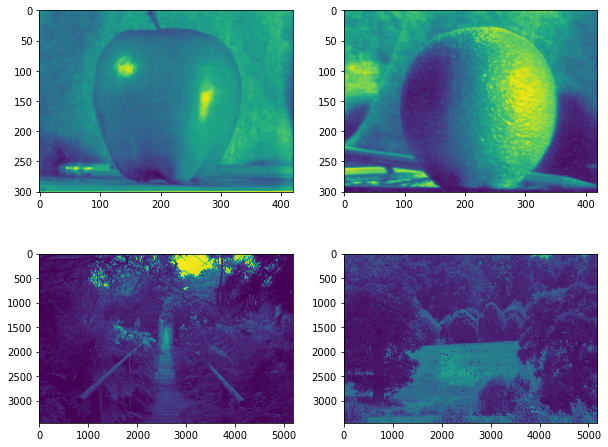

In [2]:
img1 = cv2.imread('../images/apple1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('../images/orange1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.imread('../images/IMG_4825.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
img4 = cv2.imread('../images/IMG_5024.jpg')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes[0,0].imshow(img1)
axes[0,1].imshow(img2)
axes[1,0].imshow(img3)
axes[1,1].imshow(img4)

#### Gaussian Pyramids

In [4]:
def gaussian_pyramids(img, num_steps= 3):
    gp = {}
    gp['img_0'] = img
    for j in range(num_steps):
        H, W = gp['img_'+str(j)].shape
        img_down = cv2.pyrDown(gp['img_'+str(j)], dstsize=(W//2, H//2))
        gp['img_'+str(j+1)] = img_down
    return gp

def visualize_gaussian_pyramids(gp):
    for num, k in enumerate(gp.keys()):
        plt.figure(figsize=(8/(num+1), 8/(num+1)))
        #cv2.imshow(k, gp[k])
        plt.imshow(gp[k])
        plt.title(k)
        plt.show()

#### Laplacian Pyramids

In [5]:
def make_laplacian_pyramids(gaussian_pyramids):
    gpkeys = list(gaussian_pyramids.keys())
    lp = {}
    for k in range(len(gpkeys)-1):
        img1, img2 = gaussian_pyramids[gpkeys[k]], gaussian_pyramids[gpkeys[k+1]]
        H, W = img1.shape
        img2_up = cv2.pyrUp(img2, dstsize=(W, H))
        lp[k] = img1 - img2_up
    lp[len(gpkeys)-1] = gaussian_pyramids[gpkeys[-1]]
    return lp

def visualize_laplacian_pyramids(lp):
    for num, k in enumerate(lp.keys()):
        plt.figure(figsize=(8/(num+1), 8/(num+1)))
        plt.imshow(lp[k])
        plt.title(k)
        plt.show()

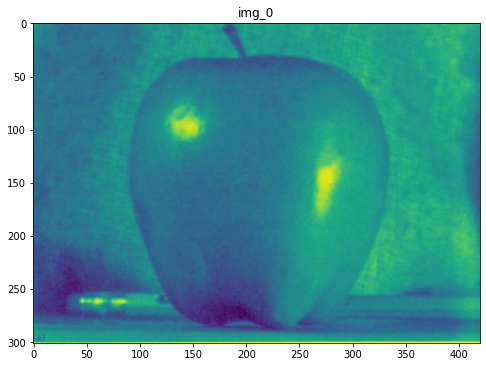

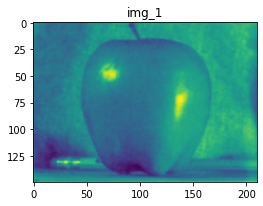

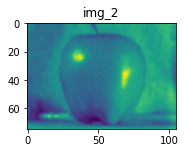

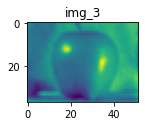

In [6]:
gp1 = gaussian_pyramids(img1)
visualize_gaussian_pyramids(gp1)

In [7]:
lp1 = make_laplacian_pyramids(gp1)

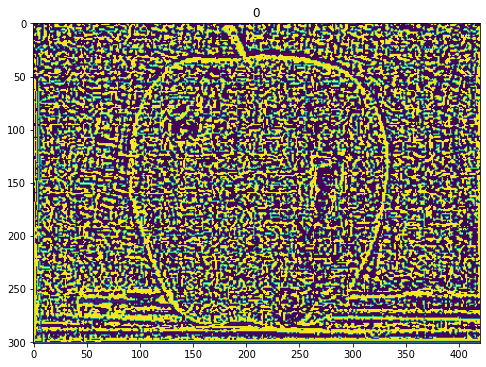

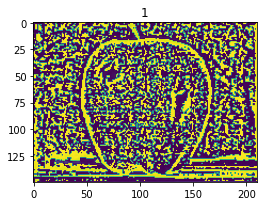

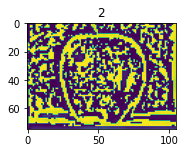

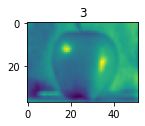

In [8]:
visualize_laplacian_pyramids(lp1)

#### Multi-level Spline

1) First compute the Laplacian pyramids $LA$ and $LB$ for images A and B
2) We then need to create a mask that will be used to blend out images.
3) Once we have a mask, we want to create a Gaussian pyramid of the mask, $GR$.
4) We now need to compute the Laplacian pyramid LS that is a combination of $LA$ and $LB$, computed by

$$LS_i = GR_i(i,j)LA_i(i,j) + (1-GR_i(i,j))LB_i(i,j)$$

5) The pyramid LS now needs to be expanded, this is done by simply upscaling and adding each level.

In [9]:
gp1 = gaussian_pyramids(img1, num_steps=6)
lp1 = make_laplacian_pyramids(gp1)
gp2 = gaussian_pyramids(img2, num_steps=6)
lp2 = make_laplacian_pyramids(gp2)

In [13]:
def create_mask(img):
    H, W = img.shape
    mask = np.zeros_like(img)
    mask[:,:W//2] = 1
    return mask

In [14]:
m1 = create_mask(img1)
img_add = m1 * img1 + (1-m1) * img2
GR = gaussian_pyramids(m1, num_steps=6)

In [15]:
def marry_laplacians(GR, lp1, lp2):
    lp_new = {}
    for l in lp1.keys():
        mask = GR['img_' + str(l)]
        lp_new[l]= mask * lp1[l] + (1-mask) * lp2[l]
    return lp_new

In [16]:
ln = marry_laplacians(GR, lp1, lp2)

In [17]:
def laplacian_collapse(ln):
    k = list(ln.keys())
    img1 = ln[len(k) - 1]
    for i in range(len(k)-1):
        img2 =  ln[len(k)-2-i]
        img1up = cv2.pyrUp(img1, dstsize=(img2.shape[1], img2.shape[0]))
        img1 = img1up + img2
    return img1

In [18]:
img_blended = laplacian_collapse(ln)

Text(0.5, 1.0, 'img2')

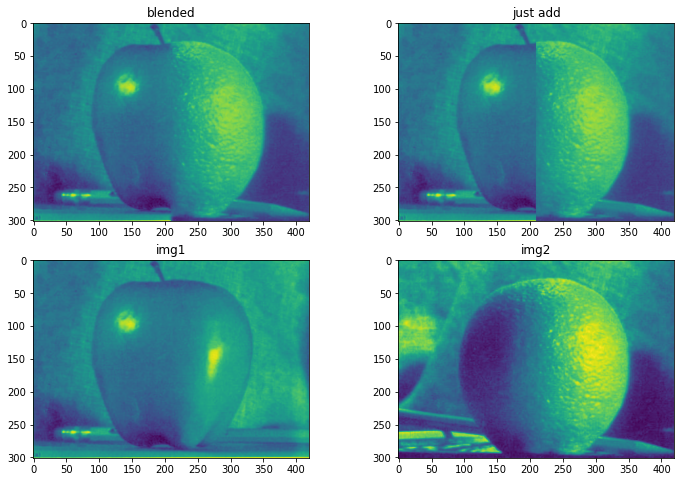

In [19]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes[0,0].imshow(img_blended)
axes[0,0].set_title('blended')
axes[0,1].imshow(img_add)
axes[0,1].set_title('just add')
axes[1,0].imshow(img1)
axes[1,0].set_title('img1')
axes[1,1].imshow(img2)
axes[1,1].set_title('img2')

### Make your own Gaussian Pyramids, Laplace Pyramids

#### Convolution

* Choose one image
* Sample Gaussian filter
* Do FFT for image and filter and multiply
* Do inverse FFT

In [186]:
# Sample Gaussian Filter
# Gaussian * Gaussian = Gaussian
def gauss2dKernel(ksizeX, ksizeY, sigmaX, sigmaY):
    gaussX = cv2.getGaussianKernel(ksizeX, sigmaX)
    gaussY = cv2.getGaussianKernel(ksizeY, sigmaY)
    gauss2d = gaussX@gaussY.T
    return gauss2d

### Gaussian Pyramid

* Use your own convolution - make Gaussian Pyramids

### Laplacian Pyramid

* Use your own convolution - make Laplacian Pyramids